<a href="https://colab.research.google.com/github/YUCAVALCANTE/ML_Studies/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# O que este bloco faz:
# 1) cria um dataset sintético de fraude fortemente desbalanceado
# 2) separa treino/teste de forma estratificada
# 3) treina um SVM (fronteira global)
# 4) treina múltiplos KNNs variando K (decisão local)
# 5) avalia com métricas focadas na classe minoritária
# 6) compara padrões de erro, não apenas valores médios

import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

# -----------------------------
# 1) Dataset sintético — fraude
# -----------------------------
rng = 42
np.random.seed(rng)

X_raw, y_raw = make_classification(
    n_samples=40000,
    n_features=18,
    n_informative=6,
    n_redundant=6,
    weights=[0.995, 0.005],  # 0.5% fraude
    class_sep=1.1,
    flip_y=0.003,
    random_state=rng
)

X = pd.DataFrame(X_raw, columns=[f"f_{i:02d}" for i in range(X_raw.shape[1])])
y = pd.Series(y_raw, name="fraud")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=rng
)

print("Proporção de fraude:", y.mean())

# -----------------------------
# 2) Modelo SVM — fronteira global
# -----------------------------
svm = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced"
    ))
])

svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)
svm_score = svm.decision_function(X_test)

print("\nSVM — Relatório:")
print(classification_report(y_test, svm_pred, digits=4))
print("PR-AUC:", average_precision_score(y_test, svm_score))
print("Matriz de Confusão:\n", confusion_matrix(y_test, svm_pred))

# -----------------------------
# 3) Modelos KNN — decisão local
# -----------------------------
ks = [3, 15, 50, 150]

for k in ks:
    knn = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(
            n_neighbors=k,
            weights="distance",
            metric="euclidean"
        ))
    ])

    knn.fit(X_train, y_train)

    knn_pred = knn.predict(X_test)
    knn_score = knn.predict_proba(X_test)[:, 1]

    print(f"\nKNN (K={k}) — Relatório:")
    print(classification_report(y_test, knn_pred, digits=4))
    print("PR-AUC:", average_precision_score(y_test, knn_score))
    print("Matriz de Confusão:\n", confusion_matrix(y_test, knn_pred))


Proporção de fraude: 0.0065

SVM — Relatório:
              precision    recall  f1-score   support

           0     0.9979    0.9831    0.9904     11922
           1     0.2078    0.6795    0.3183        78

    accuracy                         0.9811     12000
   macro avg     0.6029    0.8313    0.6544     12000
weighted avg     0.9927    0.9811    0.9860     12000

PR-AUC: 0.5515824692299883
Matriz de Confusão:
 [[11720   202]
 [   25    53]]

KNN (K=3) — Relatório:
              precision    recall  f1-score   support

           0     0.9954    1.0000    0.9977     11922
           1     1.0000    0.2949    0.4554        78

    accuracy                         0.9954     12000
   macro avg     0.9977    0.6474    0.7266     12000
weighted avg     0.9954    0.9954    0.9942     12000

PR-AUC: 0.37438178104544967
Matriz de Confusão:
 [[11922     0]
 [   55    23]]

KNN (K=15) — Relatório:
              precision    recall  f1-score   support

           0     0.9947    1.0000    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


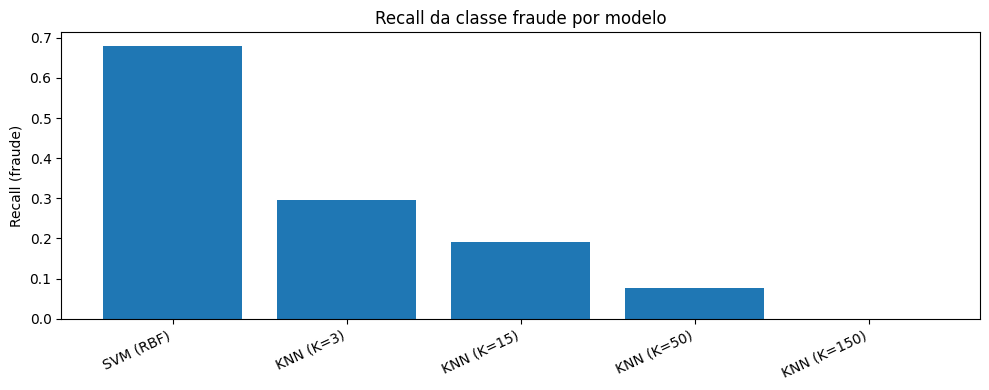

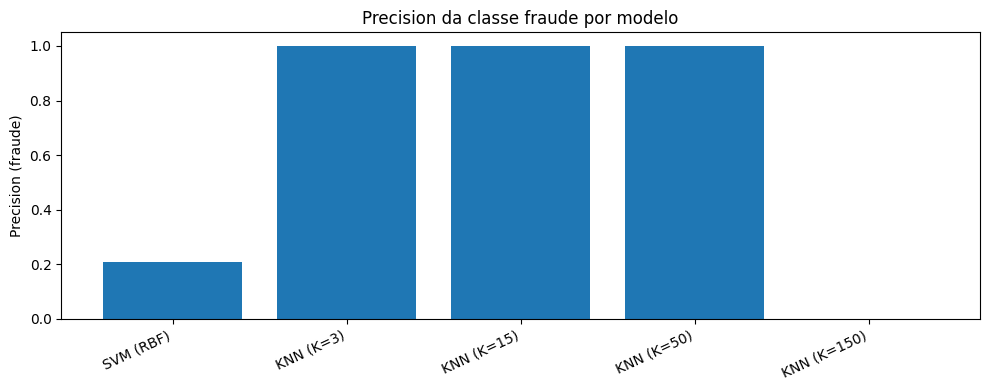

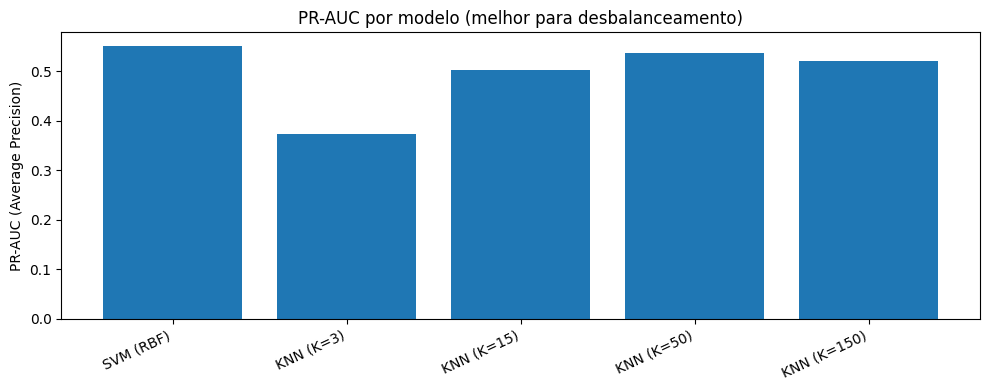

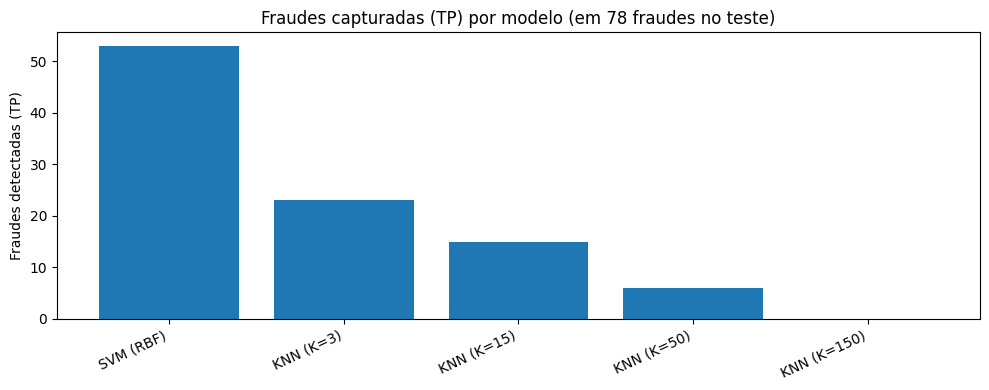

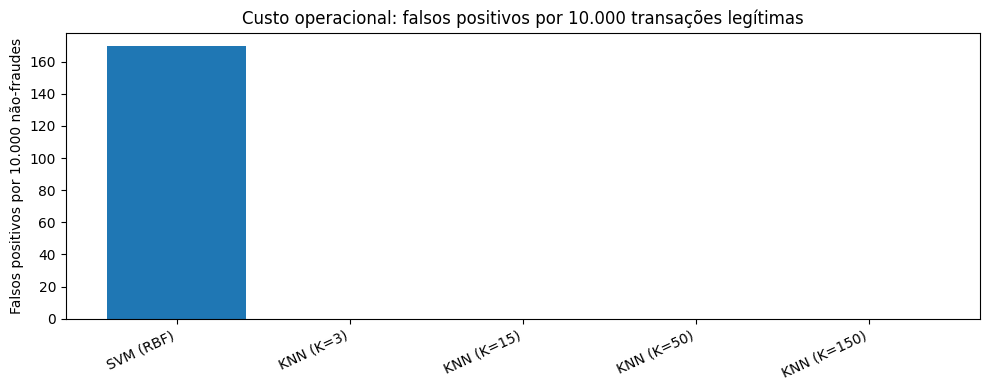

,model,precision_fraud,recall_fraud,f1_fraud,pr_auc,tn,fp,fn,tp
0,SVM (RBF),0.2078,0.6795,0.3183,0.551582,11720,202,25,53
1,KNN (K=3),1.0000,0.2949,0.4554,0.374382,11922,0,55,23
2,KNN (K=15),1.0000,0.1923,0.3226,0.503908,11922,0,63,15
3,KNN (K=50),1.0000,0.0769,0.1429,0.538036,11922,0,72,6
4,KNN (K=150),0.0000,0.0000,0.0000,0.521068,11922,0,78,0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Build a results table from the user's pasted outputs
rows = [
    {"model": "SVM (RBF)", "precision_fraud": 0.2078, "recall_fraud": 0.6795, "f1_fraud": 0.3183, "pr_auc": 0.5515824692299883,
     "tn": 11720, "fp": 202, "fn": 25, "tp": 53},
    {"model": "KNN (K=3)", "precision_fraud": 1.0, "recall_fraud": 0.2949, "f1_fraud": 0.4554, "pr_auc": 0.37438178104544967,
     "tn": 11922, "fp": 0, "fn": 55, "tp": 23},
    {"model": "KNN (K=15)", "precision_fraud": 1.0, "recall_fraud": 0.1923, "f1_fraud": 0.3226, "pr_auc": 0.5039082264379909,
     "tn": 11922, "fp": 0, "fn": 63, "tp": 15},
    {"model": "KNN (K=50)", "precision_fraud": 1.0, "recall_fraud": 0.0769, "f1_fraud": 0.1429, "pr_auc": 0.5380356315663044,
     "tn": 11922, "fp": 0, "fn": 72, "tp": 6},
    {"model": "KNN (K=150)", "precision_fraud": 0.0, "recall_fraud": 0.0, "f1_fraud": 0.0, "pr_auc": 0.5210684985502483,
     "tn": 11922, "fp": 0, "fn": 78, "tp": 0},
]
df = pd.DataFrame(rows)

# --- Visual 1: Fraud recall vs models ---
plt.figure(figsize=(10, 4))
plt.bar(df["model"], df["recall_fraud"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Recall (fraude)")
plt.title("Recall da classe fraude por modelo")
plt.tight_layout()
plt.show()

# --- Visual 2: Fraud precision vs models ---
plt.figure(figsize=(10, 4))
plt.bar(df["model"], df["precision_fraud"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Precision (fraude)")
plt.title("Precision da classe fraude por modelo")
plt.tight_layout()
plt.show()

# --- Visual 3: PR-AUC vs models ---
plt.figure(figsize=(10, 4))
plt.bar(df["model"], df["pr_auc"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("PR-AUC (Average Precision)")
plt.title("PR-AUC por modelo (melhor para desbalanceamento)")
plt.tight_layout()
plt.show()

# --- Visual 4: Confusion-matrix derived metrics (FP per 10k, TP captured) ---
df2 = df.copy()
df2["fraud_support"] = df2["tp"] + df2["fn"]
df2["tp_captured"] = df2["tp"]
df2["fp_per_10k"] = df2["fp"] / (df2["tn"] + df2["fp"]) * 10000

plt.figure(figsize=(10, 4))
plt.bar(df2["model"], df2["tp_captured"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Fraudes detectadas (TP)")
plt.title("Fraudes capturadas (TP) por modelo (em 78 fraudes no teste)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.bar(df2["model"], df2["fp_per_10k"])
plt.xticks(rotation=25, ha="right")
plt.ylabel("Falsos positivos por 10.000 não-fraudes")
plt.title("Custo operacional: falsos positivos por 10.000 transações legítimas")
plt.tight_layout()
plt.show()

df


Proporção de fraude: 0.008


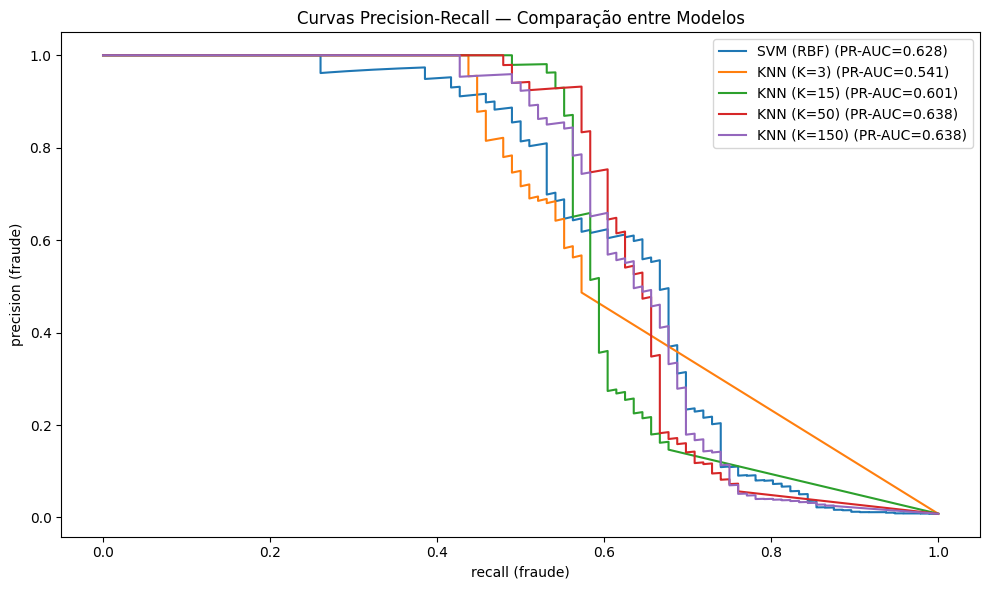

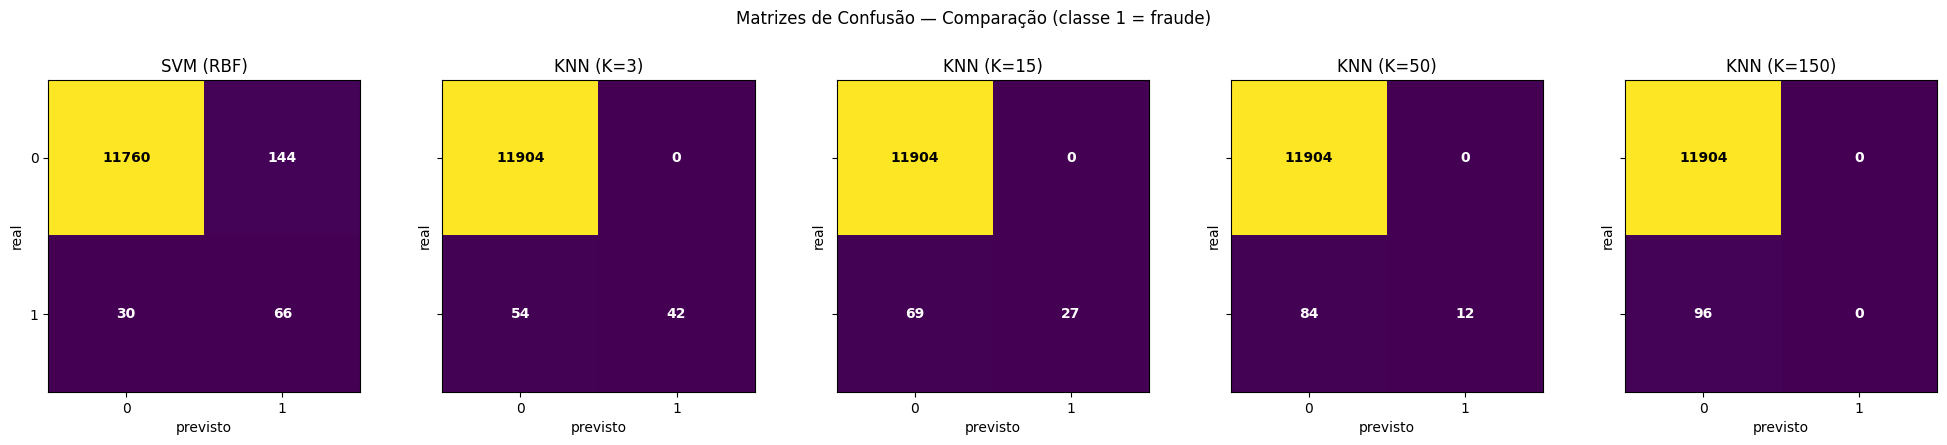

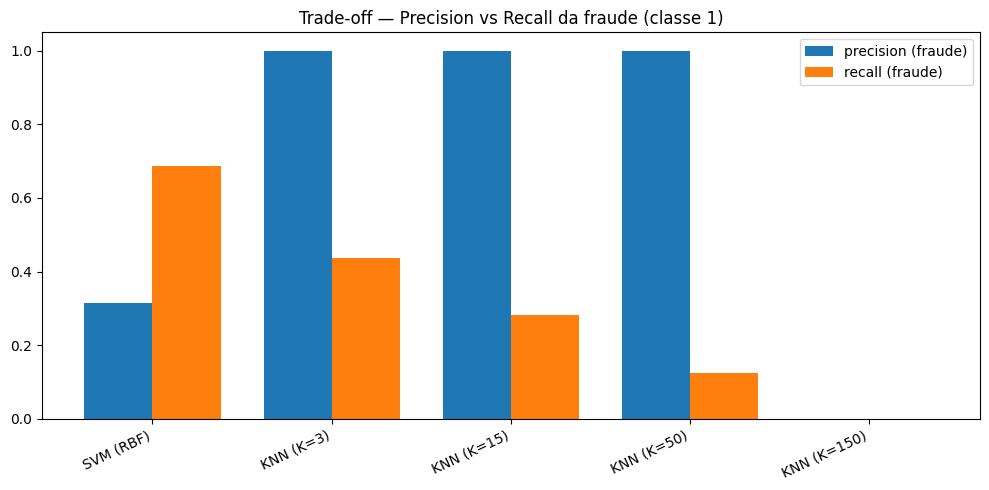

,model,precision_fraud,recall_fraud,tp,fp
0,SVM (RBF),0.314286,0.68750,66,144
1,KNN (K=3),1.000000,0.43750,42,0
2,KNN (K=15),1.000000,0.28125,27,0
3,KNN (K=50),1.000000,0.12500,12,0
4,KNN (K=150),0.000000,0.00000,0,0


In [7]:
# O que este bloco faz:
# 1) treina SVM e KNNs (vários K) e guarda y_pred e y_score
# 2) gera 3 visuais:
#    (a) Curvas Precision-Recall (uma por modelo)
#    (b) Matrizes de Confusão (painel lado a lado)
#    (c) Barras: Precision vs Recall da classe fraude (lado a lado)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)

# -----------------------------
# 0) Dataset sintético (fraude) + split estratificado
# -----------------------------
rng = 42
np.random.seed(rng)

X_raw, y_raw = make_classification(
    n_samples=40000,
    n_features=18,
    n_informative=6,
    n_redundant=6,
    weights=[0.9935, 0.0065],  # ~0.65% fraude (igual ao que você observou)
    class_sep=1.1,
    flip_y=0.003,
    random_state=rng
)

X = pd.DataFrame(X_raw, columns=[f"f_{i:02d}" for i in range(X_raw.shape[1])])
y = pd.Series(y_raw, name="fraud")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=rng
)

print("Proporção de fraude:", y.mean())

# -----------------------------
# 1) Modelos (guardando tudo em um dicionário)
# -----------------------------
models = {}

# SVM: score = decision_function
models["SVM (RBF)"] = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced"))
])

# KNN: score = predict_proba[:, 1]
for k in [3, 15, 50, 150]:
    models[f"KNN (K={k})"] = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", KNeighborsClassifier(n_neighbors=k, weights="distance"))
    ])

# -----------------------------
# 2) Treino + coleta de preds/scores
# -----------------------------
store = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # score contínuo (necessário p/ PR curve)
    if "SVM" in name:
        y_score = model.decision_function(X_test)
    else:
        y_score = model.predict_proba(X_test)[:, 1]

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # métricas da fraude (classe 1)
    precision_fraud = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall_fraud = tp / (tp + fn) if (tp + fn) > 0 else 0.0

    ap = average_precision_score(y_test, y_score)

    store[name] = {
        "y_pred": y_pred,
        "y_score": y_score,
        "cm": cm,
        "precision_fraud": precision_fraud,
        "recall_fraud": recall_fraud,
        "ap": ap,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn
    }

# -----------------------------
# 3) VISUAL A — Curvas Precision-Recall (comparação)
# -----------------------------
plt.figure(figsize=(10, 6))

for name, d in store.items():
    prec, rec, _ = precision_recall_curve(y_test, d["y_score"])
    plt.plot(rec, prec, label=f"{name} (PR-AUC={d['ap']:.3f})")

plt.title("Curvas Precision-Recall — Comparação entre Modelos")
plt.xlabel("recall (fraude)")
plt.ylabel("precision (fraude)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 4) VISUAL B — Matrizes de Confusão (painel)
# -----------------------------


names = list(store.keys())
n = len(names)

fig, axes = plt.subplots(1, n, figsize=(4*n, 4), sharey=True)

if n == 1:
    axes = [axes]

for ax, name in zip(axes, names):
    cm = store[name]["cm"]
    ax.imshow(cm, interpolation='nearest') # Adicionei interpolation para ficar mais nitido
    ax.set_title(name)
    ax.set_xlabel("previsto")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["0", "1"])
    ax.set_ylabel("real")

    # Define o limite para troca de cor (metade do valor máximo da matriz)
    thresh = cm.max() / 2.0

    # números dentro da matriz com ajuste de cor
    for (i, j), v in np.ndenumerate(cm):
        # Se o valor for menor que o limite (fundo roxo), texto branco. Senão, preto.
        color = "white" if v < thresh else "black"

        ax.text(j, i, str(v), ha="center", va="center",
                color=color, fontweight='bold') # Adicionei negrito para facilitar a leitura

fig.suptitle("Matrizes de Confusão — Comparação (classe 1 = fraude)", y=1.05)
plt.tight_layout()
plt.show()

# -----------------------------
# 5) VISUAL C — Trade-off (Precision vs Recall) lado a lado
# -----------------------------
df_metrics = pd.DataFrame({
    "model": names,
    "precision_fraud": [store[nm]["precision_fraud"] for nm in names],
    "recall_fraud": [store[nm]["recall_fraud"] for nm in names],
    "tp": [store[nm]["tp"] for nm in names],
    "fp": [store[nm]["fp"] for nm in names],
})

x = np.arange(len(df_metrics))
w = 0.38

plt.figure(figsize=(10, 5))
plt.bar(x - w/2, df_metrics["precision_fraud"], width=w, label="precision (fraude)")
plt.bar(x + w/2, df_metrics["recall_fraud"], width=w, label="recall (fraude)")
plt.xticks(x, df_metrics["model"], rotation=25, ha="right")
plt.ylim(0, 1.05)
plt.title("Trade-off — Precision vs Recall da fraude (classe 1)")
plt.legend()
plt.tight_layout()
plt.show()

df_metrics.sort_values("recall_fraud", ascending=False)
